# Exercises Week 9 in 02506: Developing a Neural Network for MNIST 

The dataset can be downloaded [as .gz files here](http://yann.lecun.com/exdb/mnist/).

<p align="center"> 
  <img src="../MNIST/raw/MNIST_images_train/image_train_00000.png" width="300" title="Very simple NN">
</p>

### Imports

In [329]:
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import cv2
from skimage.io import imshow
import random

### Pre-processing of MNIST Data

In [330]:
img_path = '../MNIST/'
raw_path = 'raw/MNIST_images_train/'
processed_path = 'processed/'
files = listdir(img_path+raw_path)
print(f"There are {np.size(files)} images")

There are 60000 images


### Loading, Transforming and Storing the Data

In [331]:
def transform(img):
    img = img.flatten() / 255.0
    img -= np.mean(img)
    img /= np.linalg.norm(img,2)
    return np.float32(np.reshape(img,[784,1]))

import os
if len(listdir(img_path+processed_path)) == 0:
    print("Directory is empty. Generating data")
    images = [transform(cv2.imread(img_path+raw_path+file, cv2.IMREAD_GRAYSCALE)) for file in files]
    labels_tmp = np.load(img_path+'raw/MNIST_target_train.npy')
    labels = []
    for i in range(np.size(labels_tmp)):
        lab = np.zeros([10,1]).astype(int)
        lab[labels_tmp[i]] = 1
        labels.append(lab)

    # Splitting into train and test sets
    print(np.array(images).shape)
    n = np.size(files)
    n_test = 10000
    l = np.arange(0,n).astype(int)
    random.shuffle(l) 
    idx_split = n-n_test;
    idx_train = l[0:idx_split].astype(int)
    idx_test =  l[idx_split-1:n-1].astype(int)
    images = np.array(images)
    np.save(img_path+processed_path+'train_images.npy', images[idx_train], allow_pickle=True, fix_imports=True)
    np.save(img_path+processed_path+'test_images.npy', images[idx_test], allow_pickle=True, fix_imports=True)
    np.save(img_path+processed_path+'train_labels.npy', labels[idx_train], allow_pickle=True, fix_imports=True)
    np.save(img_path+processed_path+'test_labels.npy', labels[idx_test], allow_pickle=True, fix_imports=True)
else:    
    print("Preprocessed data already exists")
    img_train = np.load(img_path+processed_path+'train_images.npy')
    img_test = np.load(img_path+processed_path+'test_images.npy')
    label_train = np.load(img_path+processed_path+'train_labels.npy')
    label_test = np.load(img_path+processed_path+'test_labels.npy')

Preprocessed data already exists


In [332]:
print(np.load(img_path+processed_path+'train_labels.npy').shape)

(50000, 10, 1)


### Making Mini-batches

In [333]:
def make_batches(images,labels,batch_size=20):
    M = np.shape(images)[0]
    res = []
    num_batches = np.ceil(M/batch_size).astype(int)
    for i in range(num_batches-1):
        imgs = np.hstack(images[i*batch_size:(i+1)*batch_size])
        labs = np.hstack(labels[i*batch_size:(i+1)*batch_size])
        res.append((imgs,labs))
    return res

bath_size = 20
batches_test = make_batches(img_test,label_test,batch_size=bath_size)
batches_train = make_batches(img_train,label_train,batch_size=bath_size)

### Example of Transformed Data

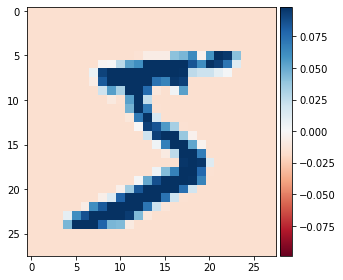

In [334]:
imshow(np.reshape(images[0],[28,28]))

### Activation Function


In [335]:
def ReLU(z):
    zbar = np.zeros(z.shape)
    idx = z > 0
    zbar[idx] = z[idx]
    return zbar

def dReLU(z):
    idx = z > 0
    return idx

def Sigmoid(z):
    return 1/(1+np.exp(-z))

def Softmax(z):
    expz = np.exp(z)
    return np.hstack([np.reshape(expz[:,i]/np.sum(expz[:,i]),[np.shape(z)[0],1]) for i in range(np.shape(z)[1])])

z = np.random.normal(0,1,size=(3,1))
print(f"z={z}")
print(f"ReLU(z)={ReLU(z)}")
print(f"Sigmoid(z)={Sigmoid(z)}")
print(f"Softmax(z)={Softmax(z)}")

z=[[-0.53857787]
 [-1.15497786]
 [ 1.4444091 ]]
ReLU(z)=[[0.       ]
 [0.       ]
 [1.4444091]]
Sigmoid(z)=[[0.36851847]
 [0.23958103]
 [0.8091365 ]]
Softmax(z)=[[0.11358094]
 [0.0613206 ]
 [0.82509846]]


### Initializing Arrays

In [336]:
def init(rows,cols=1):
    z = np.random.normal(0,1,size=(rows,cols))
    return np.sqrt(2/(rows))*z

print(f"init(4,2)={init(4,2)}")

init(4,2)=[[ 0.66881219 -0.12835378]
 [-0.28235807  0.29612267]
 [ 0.22611494  0.7768242 ]
 [-0.03145103  1.66187164]]


### Defining a Linear Layer

In [337]:
class LinearLayer:
    def __init__(self,N_in,N_out):
        self.weights = init(N_out,N_in+1)
        self.N_in = N_in
        self.N_out = N_out

    def forward(self,X):
        return self.weights@np.vstack((X,np.ones([1,np.shape(X)[1]])))

LL1 = LinearLayer(3,4)
X = np.random.normal(-1,1,size=(3,4))
Y = LL1.forward(X)
print(f"forward({X})\n={Y}")

forward([[-1.32947901 -2.11792731 -0.68307445 -1.33515291]
 [-1.94029014  0.33807942 -1.26217796 -2.35379755]
 [-1.07179887 -0.21159967 -1.07425345 -2.17182546]])
=[[-2.43069011 -1.6952643  -1.88983859 -2.76155908]
 [-0.2878611   1.53740406 -0.73993246 -0.60968701]
 [ 2.53907882  0.32393777  1.66615739  4.68018248]
 [-0.25081316  0.13843728  0.23693195  0.26061576]]


### Defining Cross Entropy Loss


In [338]:
def argmax(Y):
    Ytmp = np.array(Y).argmax(axis=0)
    Y = np.array([Y[:,i] == Y[Ytmp[i],i] for i in range(np.size(Ytmp))]).T
    return Y
    #return z.a.argmax(axis=0)
    
def CrossEntropyLoss(Y,T):
    Y = Y.flatten()
    T = T.flatten()
    return np.sum(-np.log(Y[T>0]+0.0000001))/np.sum(T)

T = argmax(Y)
print(f"CrossEntropyLoss(Y,T)={CrossEntropyLoss(Y,T)}")

CrossEntropyLoss(Y,T)=-0.8539384909288525


### Defining A Neural Network Class

In [339]:
class NeuralNetwork:
    def __init__(self,shapes,act_funs,diff_act_funs,seed = 1234):
        np.random.seed(seed)
        self.layers = []
        self.act_funs = act_funs
        self.diff_act_funs = diff_act_funs
        self.length = np.size(act_funs)
        assert(self.length == np.size(shapes)-1)
        self.h = []
        self.h.append([])
        self.a = []
        for i in range(self.length):
            self.layers.append(LinearLayer(shapes[i],shapes[i+1]))
        self.init_grads(shapes)

    def init_grads(self,shapes):
        for i in range(self.length):
            self.h.append(np.zeros([]))
            self.a.append(np.zeros([]))
    
    def zero_grads(self):
        self.h[0] = np.zeros(self.h[0].shape)
        for i in range(self.length):
            self.h[i+1] = np.zeros(self.h[i+1].shape)
            self.a[i] = np.zeros(self.a[i].shape)
    
    def forward(self,X):
        self.h[0] = X
        for i in range(self.length):
            X = self.layers[i].forward(X)
            self.h[i+1] = X
            self.a[i] = self.diff_act_funs[i](X)
            X = self.act_funs[i](X)
        return X

    def backward(self,Y,T,L,lr=0.01):
        d = Y-np.float32(T)
        h = []
        for i,hi in enumerate(self.h):
            h.append(np.vstack((hi,np.ones([1,np.shape(hi)[1]]))))
        W = []
        for i,layer in enumerate(self.layers):
            wi = layer.weights
            #print(f"w{i}={wi}")
            W.append(wi[:,:-1])
        for i in range(self.length-1,-1,-1):
            Q = h[i]@d.T
            Q /= np.shape(T)[1]
            if i>0:
                d = np.multiply(self.a[i-1],W[i].T@d)
            # Updating weights
            self.layers[i].weights -= lr*Q.T
            #print(i)
        
        #for i,layer in enumerate(self.layers):
            #wi = layer.weights
            #print(f"w{i}={wi}")
        self.zero_grads()

X,T = batches_train[0]
NN = NeuralNetwork([784,999,299,10],[ReLU,ReLU,Softmax],[dReLU,dReLU,dReLU])
Y = NN.forward(X)
L = CrossEntropyLoss(Y,T)
NN.backward(Y,T,L)
print(f"NN(X)\n={Y}")

NN(X)
=[[0.05699141 0.07060001 0.09185873 0.05778886 0.10397362 0.03723531
  0.12642696 0.0506133  0.1079732  0.1057151  0.08875705 0.08667357
  0.06575804 0.0836954  0.05311516 0.10498198 0.07579047 0.0689841
  0.10567771 0.05373376]
 [0.02833635 0.03098469 0.02656457 0.02125362 0.01935052 0.04796147
  0.02404272 0.04235674 0.02355576 0.03267279 0.01850016 0.02752509
  0.01482372 0.02869903 0.02310147 0.02902489 0.02920476 0.02223692
  0.01418409 0.04112593]
 [0.0352317  0.09110745 0.07571691 0.11508177 0.04128497 0.06995315
  0.06700103 0.05416356 0.06870801 0.08383173 0.05707935 0.0599572
  0.03551781 0.06154602 0.06620037 0.06720604 0.17020971 0.06437346
  0.0648715  0.06140957]
 [0.01951836 0.03915864 0.02964296 0.01741225 0.0191003  0.03203485
  0.02281085 0.02190999 0.04615223 0.03871541 0.01839582 0.02932595
  0.01678161 0.02416723 0.01267086 0.02889131 0.05562567 0.02520626
  0.0243705  0.03223764]
 [0.06632138 0.07165983 0.0615663  0.05888918 0.06248075 0.07194125
  0.0449460

### Training

In [343]:
NN = NeuralNetwork([784,999,299,10],[ReLU,ReLU,Softmax],[dReLU,dReLU,dReLU])

train_loss = []
val_loss = []

epochs = 15

N_train = 100 #np.size(batches_train)
N_test = 10 #np.shape(batches_test)

for e in range(epochs):
    train_l = 0
    for i in range(N_train):
        x,t = batches_train[i]
        y = NN.forward(x)
        t = t.astype(bool)
        l = CrossEntropyLoss(y,t)
        NN.backward(y,t,l,lr=0.001)
        train_l += l
    train_loss.append(train_l/N_train)
    val_l = 0
    for i in range(N_test):
        x,t  = batches_test[i]
        y = NN.forward(x)
        t = t.astype(bool)
        l = CrossEntropyLoss(y,t)
        val_l += l
    NN.zero_grads()
    val_loss.append(val_l/N_test)

### Evaluating Results

<bound method Figure.show of <Figure size 864x288 with 1 Axes>>

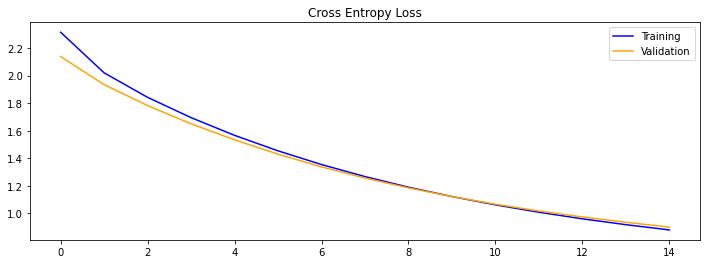

In [344]:
#class1 = np.where(np.equal(preds,0))
#class2 = np.where(np.equal(preds,1))
#print(f"Prob of class 1 = {sum(np.equal(preds,0))/(2*N)}")
#print(f"Prob of class 2 = {sum(np.equal(preds,1))/(N*2)}")

fig, (ax1) = plt.subplots(1,1,figsize=(12,4))
ax1.plot(range(0,epochs),train_loss,c = 'blue',label='Training')
ax1.plot(range(0,epochs),val_loss,c = 'orange',label='Validation')
ax1.legend()
ax1.set_title("Cross Entropy Loss")
fig.show